# Fine-tuning a custom dataset for image captioning

Example follows https://huggingface.co/docs/transformers/main/tasks/image_captioning and https://github.com/NielsRogge/Transformers-Tutorials/blob/master/GIT/Fine_tune_GIT_on_an_image_captioning_dataset.ipynb

Leukemia data from https://www.kaggle.com/datasets/mehradaria/leukemia

## Sample Pokemon Dataset

In [1]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")

Data comprises image/text (caption) pairs

In [2]:
print(ds)
print(ds['train'][0])

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280 at 0x7F854C599DC0>, 'text': 'a drawing of a green pokemon with red eyes'}


In [3]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

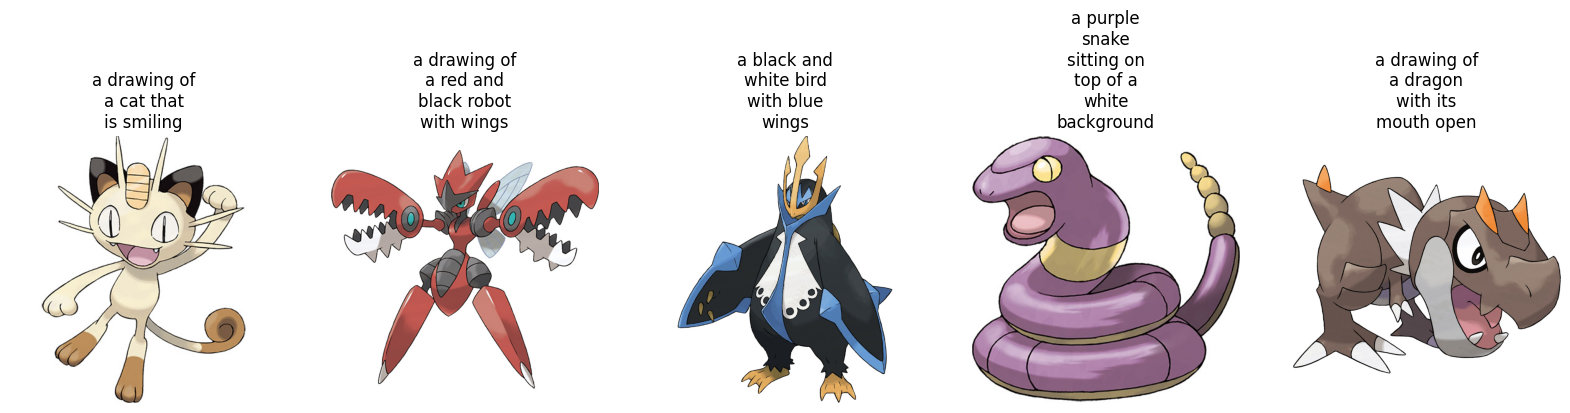

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess Data

Resize/pixel scale the image and tokenize the caption

In [5]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

2023-09-16 11:55:32.611850: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-16 11:55:32.637949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 11:55:33.037918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [7]:
train_dataset = ImageCaptioningDataset(train_ds, processor)
test_dataset = ImageCaptioningDataset(test_ds, processor)

In [8]:
for k,v in train_dataset[0].items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## PyTorch DataLoader

Allows us to get batches of data from the dataset

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
validation_dataloader = DataLoader(test_dataset, batch_size=4)

In [10]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
pixel_values torch.Size([4, 3, 224, 224])


In [11]:
processor.decode(batch["input_ids"][0])

'[CLS] a drawing of a blue and orange pokemon [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## Model

In [12]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [13]:
#Dummy pass on our batch to check initial loss
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.9372, grad_fn=<NllLossBackward0>)

## Training

In [14]:
import torch
from jiwer import wer

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

# Training loop
num_epochs = 1  # Adjust as needed
for epoch in range(num_epochs):
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        labels=input_ids)

        loss = outputs.loss

        print(f"Epoch {epoch+1}, Batch {idx+1}, Loss: {loss.item()}")

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    # Validation loop
    model.eval()
    total_wer_score = 0.0
    with torch.no_grad():
        for batch in validation_dataloader:
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            attention_mask = batch.pop("attention_mask").to(device)
            labels = input_ids  # Using input_ids as labels

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=labels)

            predicted = outputs.logits.argmax(-1)
            decoded_labels = processor.batch_decode(labels.cpu().numpy(), skip_special_tokens=True)
            decoded_predictions = processor.batch_decode(predicted.cpu().numpy(), skip_special_tokens=True)
            
            wer_score = wer(decoded_labels, decoded_predictions)
            total_wer_score += wer_score

    average_wer_score = total_wer_score / len(validation_dataloader)
    print(f"WER Score after Epoch {epoch+1}: {average_wer_score}")

    model.train()

Epoch 1, Batch 1, Loss: 11.763141632080078
Epoch 1, Batch 2, Loss: 10.394330024719238
Epoch 1, Batch 3, Loss: 9.955245018005371
Epoch 1, Batch 4, Loss: 9.637685775756836
Epoch 1, Batch 5, Loss: 9.39003849029541
Epoch 1, Batch 6, Loss: 9.17910099029541
Epoch 1, Batch 7, Loss: 8.981953620910645
Epoch 1, Batch 8, Loss: 8.81518840789795
Epoch 1, Batch 9, Loss: 8.64402961730957
Epoch 1, Batch 10, Loss: 8.518741607666016
Epoch 1, Batch 11, Loss: 8.400364875793457
Epoch 1, Batch 12, Loss: 8.259146690368652
Epoch 1, Batch 13, Loss: 8.142157554626465
Epoch 1, Batch 14, Loss: 8.050037384033203
Epoch 1, Batch 15, Loss: 7.961704254150391
Epoch 1, Batch 16, Loss: 7.852353572845459
Epoch 1, Batch 17, Loss: 7.723320484161377
Epoch 1, Batch 18, Loss: 7.640230178833008
Epoch 1, Batch 19, Loss: 7.52309513092041
Epoch 1, Batch 20, Loss: 7.424395561218262
Epoch 1, Batch 21, Loss: 7.357559680938721
Epoch 1, Batch 22, Loss: 7.247094631195068
Epoch 1, Batch 23, Loss: 7.121255397796631
Epoch 1, Batch 24, Loss

Epoch 1, Batch 186, Loss: 0.0718505010008812
Epoch 1, Batch 187, Loss: 0.07514640688896179
Epoch 1, Batch 188, Loss: 0.07155976444482803
WER Score after Epoch 1: 0.3945097142321956


## Inference

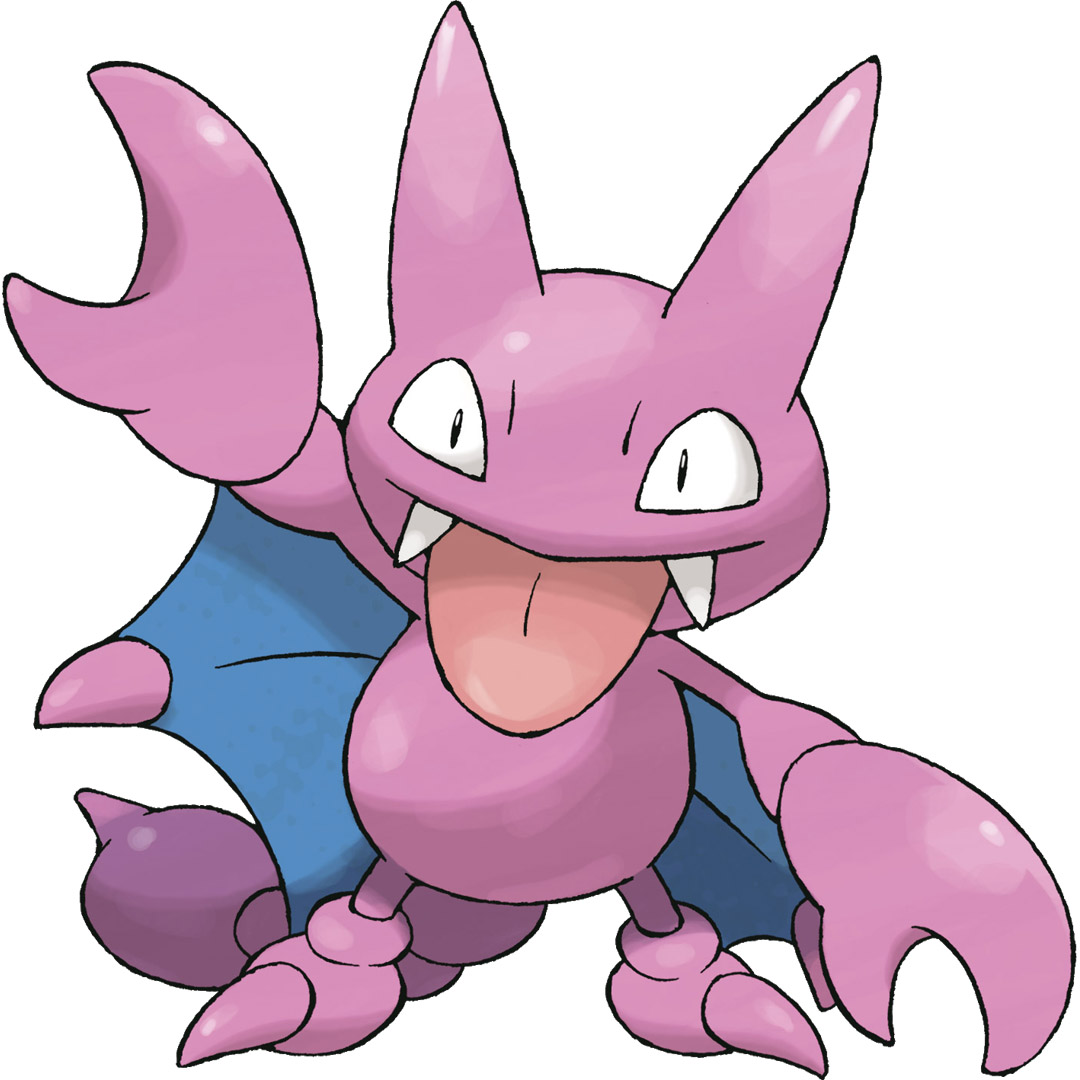

In [15]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a cartoon character with a pink nose and a blue nose
